In [1]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import os
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import  RF_regressor, plot_importances, XGBoost_regressor, Tu_label, encode_tulabel, XGBoost_regressor_tuned
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.models.corr_func import calc_correlation, plot_correlations, correlation_matrix
from src.models.learning_curve import learning_curve
from src.utils.directories import get_parent_directory
from src.models.corr_func import score_metrics, confidence_metrics

In [2]:
parent_dir = get_parent_directory()
parent_dir

'/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence'

In [3]:
# Bathymetry dataset
GEBCO_ds = os.path.join(parent_dir, "data/external/GEBCO/gebco_2022_n80.0_s63.0_w-170.0_e-130.0.nc")
bathy_ds = xr.open_dataset(GEBCO_ds)

In [4]:
# arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/arctic2_1805.pkl'
arctic_pkl = os.path.join(parent_dir, 'data/processed/ml_ready/3206_plotL.pkl')
arctic_df = pd.read_pickle(arctic_pkl)

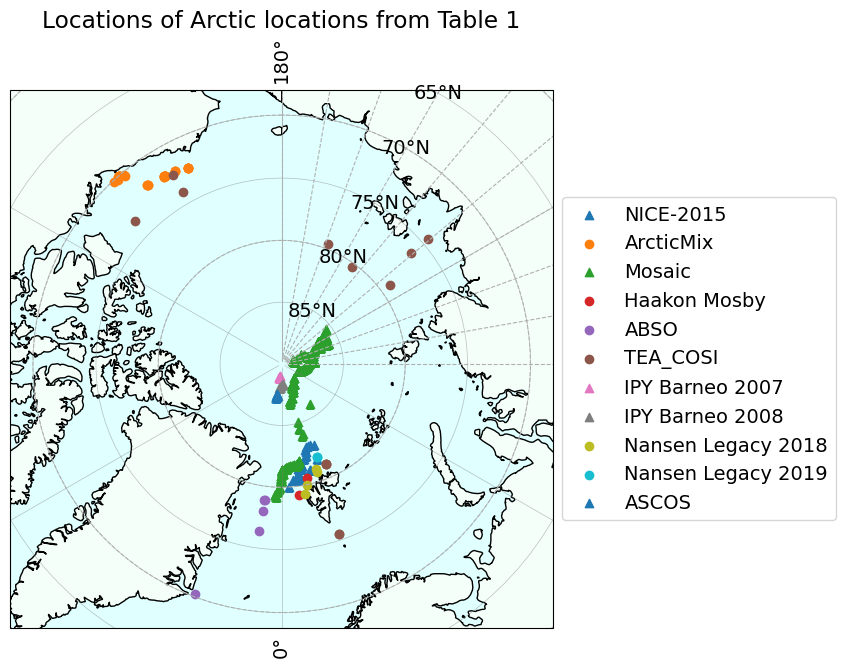

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools
import random
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def stereo_cruise_plot(merged_df):
    # Create a polar stereographic projection centered on the Arctic pole
    projection = ccrs.NorthPolarStereo(central_longitude=0)

    # Get unique cruise names and assign a unique color to each name
    cruise_names = merged_df['cruise'].unique()
    colors = itertools.cycle(mcolors.TABLEAU_COLORS)

    # Filter merged_df for unique latitudes
    unique_latitudes = merged_df['latitude'].unique()

    # Create a figure and axes using the polar stereographic projection
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': projection})

    # Plot the ocean as light blue
    ax.add_feature(cfeature.OCEAN, facecolor='lightcyan', edgecolor='black')

    # Plot the land as light green
    ax.add_feature(cfeature.LAND, facecolor='mintcream', edgecolor='black')

    # Plot longitude and latitude with colored residuals based on cruise name
    for cruise in cruise_names:
        cruise_data = merged_df.loc[merged_df['cruise'] == cruise]
        # Check if the latitude is unique
        if cruise_data['latitude'].iloc[0] in unique_latitudes:
            color = next(colors)
            # Set marker shape based on sea ice concentration
            marker = '^' if cruise_data['sea_ice_concentration'].iloc[0] > 0.7 else 'o'
            
            # Select a random sample of 5% of the points for each cruise
            cruise_data_sampled = cruise_data.sample(frac=0.05, random_state=42)
            if cruise == "Mosaic" or cruise == "TEA-COSI":
                cruise_data_sampled = cruise_data.sample(frac=0.9, random_state=42)
            
            ax.scatter(cruise_data_sampled['longitude'], cruise_data_sampled['latitude'],
                       color=color, marker=marker, label=cruise, transform=ccrs.PlateCarree())

    # Set map extent to focus on the Arctic region
    ax.set_extent([-180, 180, 68, 90], ccrs.PlateCarree())

    # Add gridlines with latitude and longitude labels
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
    ax.gridlines(xlocs=range(90, 271, 10), ylocs=range(60, 91, 10), linestyle='--')

    # Set plot title and labels
    plt.title("Locations of Arctic locations from Table 1")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Place the legend outside the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot
    plt.show()

# Filter arctic_df for unique latitudes
unique_latitudes_df = arctic_df.drop_duplicates(subset=['latitude'])

# Plot a random sample of 5% of the points from each cruise at unique latitudes
stereo_cruise_plot(unique_latitudes_df)

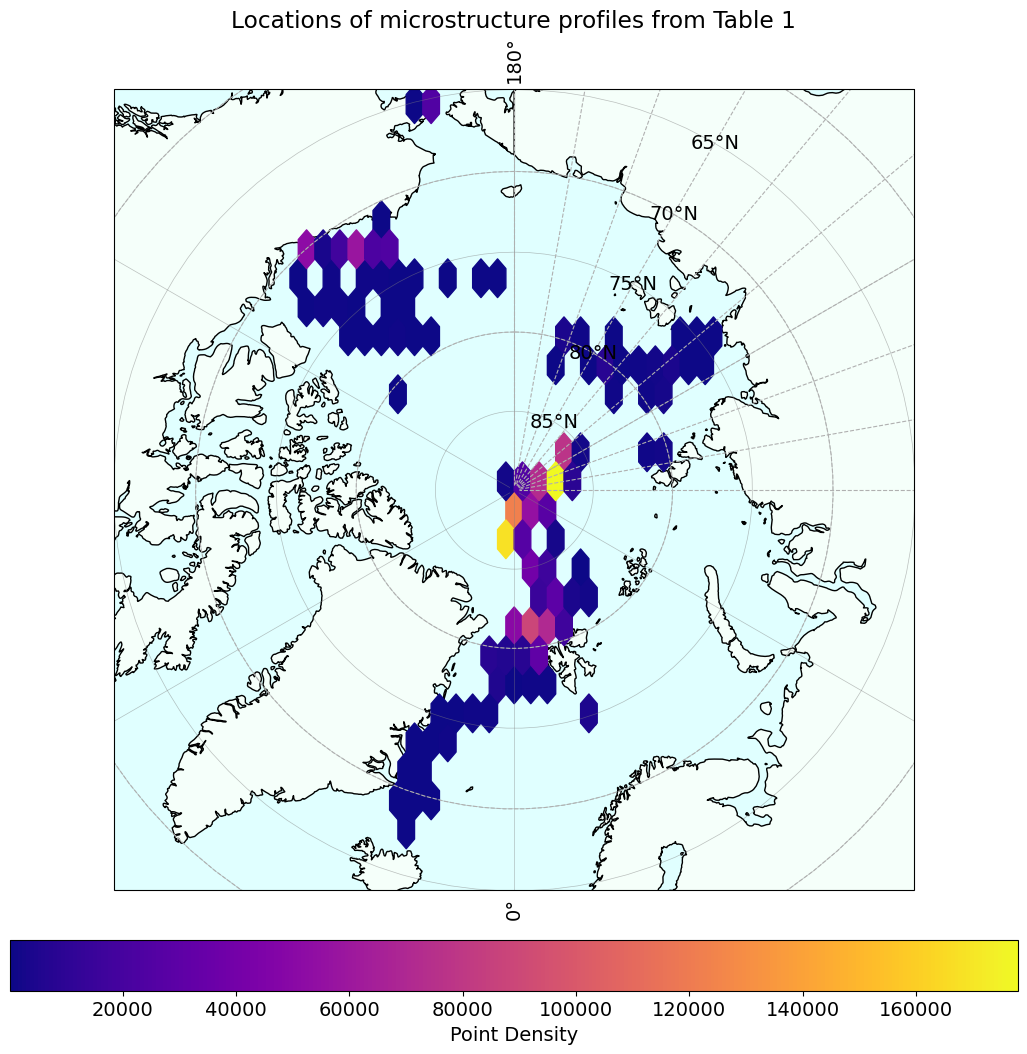

In [6]:
def pointdensity_cruise_plot(merged_df):
    # Create a polar stereographic projection centered on the Arctic pole
    projection = ccrs.NorthPolarStereo(central_longitude=0)

    # Get unique cruise names and assign a unique color to each name
    cruise_names = merged_df['cruise'].unique()
    colors = itertools.cycle(mcolors.TABLEAU_COLORS)

    # Create a figure and axes using the polar stereographic projection
    fig, ax = plt.subplots(figsize=(13, 13), subplot_kw={'projection': projection})

    # Plot the ocean as light blue
    ax.add_feature(cfeature.OCEAN, facecolor='lightcyan', edgecolor='black')

    # Plot the land as light green
    ax.add_feature(cfeature.LAND, facecolor='mintcream', edgecolor='black')

    # Compute point density using hexbin
    hb = ax.hexbin(
        merged_df['longitude'], merged_df['latitude'], gridsize=25,
        cmap='plasma', transform=ccrs.PlateCarree(), mincnt=1
    )

    # Get the counts and bin locations from the hexbin object
    counts = hb.get_array()
    x = hb.get_offsets()[:, 0]
    y = hb.get_offsets()[:, 1]

    # Set transparency for bins with count 0
    cmap = plt.cm.get_cmap('Blues')
    cmap.set_under(alpha=0)

    # Plot the hexbin points with transparency based on counts
    ax.scatter(
        x, y, c=counts, cmap=cmap, alpha=0.8, transform=ccrs.PlateCarree()
    )

    # Set map extent to focus on the Arctic region
    ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())

    # Add gridlines with latitude and longitude labels
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
    ax.gridlines(xlocs=range(90, 271, 10), ylocs=range(60, 91, 10), linestyle='--')

    # Set plot title and labels
    plt.title("Locations of microstructure profiles from Table 1")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Add colorbar for point density
    cbar = plt.colorbar(hb, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label('Point Density')

    # Show the plot
    plt.show()

pointdensity_cruise_plot(arctic_df)